In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

In [2]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json?$limit=50000"

params = {'$where' : "incident_reported between '2021-01-13T00:00:00.000' and '2021-06-30T00:00:00.000'", 
}

In [3]:
response = requests.get(endpoint, params)

In [4]:
res = response.json()

In [5]:
res_trimmed=pd.DataFrame(res, columns=['incident_reported', 'offense_description', 'latitude', 'longitude', 'zip_code'])
res_trimmed['incident_reported'] = res_trimmed['incident_reported'].str.split("T", expand=True)[0]

burglary_reports = res_trimmed[res_trimmed['offense_description'].str.contains('BURGLARY- AGGRAVATED')]

burglary_reports.head()


,incident_reported,offense_description,latitude,longitude,zip_code
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN
450,2021-01-14,BURGLARY- AGGRAVATED,36.04,-86.73,NaN
495,2021-01-14,BURGLARY- AGGRAVATED,36.16,-86.85,NaN


In [6]:
burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']].apply(pd.to_numeric);

burglary_reports.shape

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(984, 5)

Downloaded census tract data and uploaded code

In [7]:
census_tract = gpd.read_file('../tl_2019_47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [8]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


Created appropriate 'geometry' column with Point(long, lat) format and converted to GeoDataFrame

In [9]:

burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,
                                                                      x.latitude)),
                                                     axis=1)

burglary_reports.head()

C:\Users\U6033919\AppData\Local\Temp/ipykernel_34748/956467498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude,


,incident_reported,offense_description,latitude,longitude,zip_code,geometry
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN,POINT (-86.95 36.06)
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN,POINT (-86.75 36.19)
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN,POINT (-86.75 36.18)
450,2021-01-14,BURGLARY- AGGRAVATED,36.04,-86.73,NaN,POINT (-86.73 36.04)
495,2021-01-14,BURGLARY- AGGRAVATED,36.16,-86.85,NaN,POINT (-86.84999999999999 36.16)


In [10]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                               crs=census_tract.crs,
                               geometry = burglary_reports['geometry'])

Paired down census_tract usable columns and joined with burglary_geo data

In [11]:
census_tract = census_tract[['COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)
census_tract = census_tract[census_tract['COUNTYFP'] == 37]
census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [12]:
burglary_by_tract = gpd.sjoin(burglary_geo, census_tract, op = 'within')

Gets rid of duplicates in data and adjusts columns

In [13]:
burglary_by_tract.drop_duplicates(subset='geometry', inplace=True)
burglary_by_tract = burglary_by_tract.drop(columns='index_right')
burglary_by_tract = burglary_by_tract.rename(columns={'TRACTCE':'tract'})
burglary_by_tract.head()

,incident_reported,offense_description,latitude,longitude,zip_code,geometry,COUNTYFP,tract,NAME
199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,NaN,POINT (-86.95000 36.06000),37,018407,184.07
14375,2021-03-05,BURGLARY- AGGRAVATED,36.07,-86.99,NaN,POINT (-86.99000 36.07000),37,018407,184.07
310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,NaN,POINT (-86.75000 36.19000),37,011700,117
2779,2021-01-22,BURGLARY- AGGRAVATED,36.19,-86.74,NaN,POINT (-86.74000 36.19000),37,011700,117
434,2021-01-14,BURGLARY- AGGRAVATED,36.18,-86.75,NaN,POINT (-86.75000 36.18000),37,011900,119


Creates polygon objects of tracts of only Davidson county

In [14]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)
polygon_nash = pd.merge(census_tract, census_tract_names, on = 'NAME')
polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
2,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
6,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
10,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
12,37,010602,106.02,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."
...,...,...,...,...
397,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
399,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
400,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
404,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


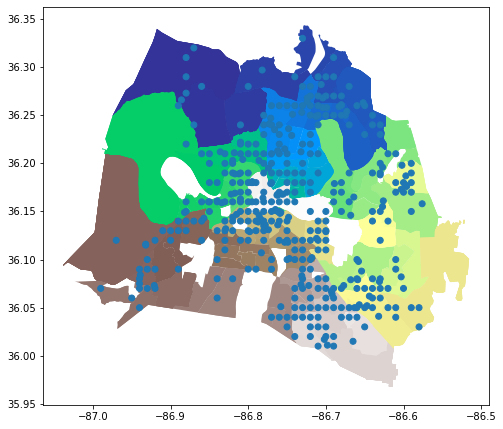

In [15]:
ax = polygon_nash.plot(column='TRACTCE', figsize = (8, 10), cmap='terrain')
burglary_by_tract.plot(ax = ax, column = 'offense_description')
plt.show();

Imports Census data

In [16]:
with open('../api_key') as fi:
    credentials = json.load(fi)
       
api_key = credentials['api_key']

In [17]:
endpoint_pop = "https://api.census.gov/data/2019/acs/acs5"
params_pop = {
       'get' : 'NAME,B01001_001E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : api_key
}

endpoint_income = "https://api.census.gov/data/2019/acs/acs5/subject"
params_income = {
       'get' : 'NAME,S1901_C01_012E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : api_key
}

In [18]:
response_pop = requests.get(endpoint_pop, params=params_pop)

response_income = requests.get(endpoint_income, params=params_income)

In [19]:
res_pop = response_pop.json()
population = pd.DataFrame(res_pop)
#changes column names
population.columns = population.iloc[0]
population = population[1:]
display(population.head())

res_income = response_income.json()
med_income = pd.DataFrame(res_income) 
#changes colum names 
med_income.columns = med_income.iloc[0]
med_income = med_income[1:]
display(med_income.head())

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301


,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",75579,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",45129,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",134786,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",107813,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",87591,47,037,018301


Merges census data together and renames columns

In [20]:
pop_and_income = pd.merge(population, med_income, how='inner')
pop_and_income = pop_and_income.rename(columns={'B01001_001E': 'population',
                                               'S1901_C01_012E':'median_income'})
pop_and_income.head()

,NAME,population,state,county,tract,median_income
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75579
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,45129
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,134786
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,107813
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,87591


In [21]:
burglaries_and_var = pd.merge(burglary_by_tract, pop_and_income, on='tract')
burglaries_and_var = burglaries_and_var.drop(columns=['latitude', 'longitude', 'zip_code','NAME_x','NAME_y'])
burglaries_and_var.head()

,incident_reported,offense_description,geometry,COUNTYFP,tract,population,state,county,median_income
0,2021-01-13,BURGLARY- AGGRAVATED,POINT (-86.95000 36.06000),37,018407,5001,47,037,105917
1,2021-03-05,BURGLARY- AGGRAVATED,POINT (-86.99000 36.07000),37,018407,5001,47,037,105917
2,2021-01-14,BURGLARY- AGGRAVATED,POINT (-86.75000 36.19000),37,011700,5971,47,037,68889
3,2021-01-22,BURGLARY- AGGRAVATED,POINT (-86.74000 36.19000),37,011700,5971,47,037,68889
4,2021-01-14,BURGLARY- AGGRAVATED,POINT (-86.75000 36.18000),37,011900,2530,47,037,51168


In [22]:
burlglaries_per_tract=burglaries_and_var.groupby(['tract', 'population', 'state', 'county', 'median_income']).agg({'incident_reported': 'count'})

In [23]:
burlglaries_per_tract.head()

,,,,,incident_reported
tract,population,state,county,median_income,
010104,2955,47,037,64844,4
010105,4435,47,037,64688,3
010106,3397,47,037,63864,2
010201,4157,47,037,62829,3
010301,3395,47,037,51918,1


In [24]:
import numpy as np

In [25]:
rate_of_burg = burlglaries_per_tract.reset_index()
rate_of_burg['rate_of_burg']= (rate_of_burg['incident_reported']/np.log(rate_of_burg['population'].astype(float)))
rate_of_burg

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,tract,population,state,county,median_income,incident_reported,rate_of_burg
0,010104,2955,47,037,64844,4,0.500547
1,010105,4435,47,037,64688,3,0.357258
2,010106,3397,47,037,63864,2,0.245983
3,010201,4157,47,037,62829,3,0.360034
4,010301,3395,47,037,51918,1,0.123000
...,...,...,...,...,...,...,...
141,019300,3428,47,037,14277,7,0.859979
142,019400,5810,47,037,81286,5,0.576879
143,019500,7956,47,037,75446,7,0.779364
144,019600,3843,47,037,59072,4,0.484613


In [89]:
rate_of_burg=rate_of_burg[rate_of_burg['population'] > 0]

In [90]:
rate_of_burg[rate_of_burg['median_income'] <= 0]

,tract,population,state,county,median_income,incident_reported,rate_of_burg,fit_values


In [30]:
rate_of_burg=rate_of_burg[rate_of_burg['median_income'] > '0']

In [91]:
rate_of_burg['rate_of_burg'].mean()

0.3424585248987106

In [92]:
rate_of_burg['rate_of_burg'].var()

0.03519202317376757

In [109]:

#rate_of_burg.plot(x='tract',y='incident_reported', kind='bar',rot=45);


In [32]:
import statsmodels.api as sm
rate_of_burg['population'] = rate_of_burg['population'].astype(float)
rate_of_burg['median_income'] = rate_of_burg['median_income'].astype(float)

In [33]:
poisreg_population= (sm.GLM(endog = rate_of_burg['rate_of_burg'],
                         exog = sm.add_constant(rate_of_burg[['population']]),
                         family = sm.families.Poisson())
                      .fit()
                     )

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
poisreg_population.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           rate_of_burg   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.824
Date:                Tue, 12 Oct 2021   Deviance:                       12.978
Time:                        11:42:33   Pearson chi2:                     13.5
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3942      0.356     -3.917      0.000      -2.092      -0.697
population  7.029e-05    6.9e-05      1.019      0.308   -6.49e-05       0.000
==============================================================================
"""

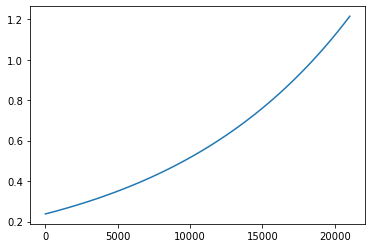

In [35]:
info = rate_of_burg.describe()
t = np.linspace(0, 1.5*info['population']['max'],50)
y = np.exp(-1.4363 + 7.755e-05 *t)
plt.plot(t,y);

In [107]:
#poisreg_population.fittedvalues

In [108]:
#plt.plot(poisreg_population.fittedvalues, rate_of_burg['rate_of_burg'] - poisreg_population.fittedvalues , '+', )

In [38]:
poisreg_income= (sm.GLM(endog = rate_of_burg['rate_of_burg'],
                         exog = sm.add_constant(rate_of_burg[['median_income']]),
                         family = sm.families.Poisson()) 
                 .fit()
                )

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
poisreg_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           rate_of_burg   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.735
Date:                Tue, 12 Oct 2021   Deviance:                       12.799
Time:                        11:42:47   Pearson chi2:                     13.3
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7080      0.372     -1.903      0.057      -1.437       0.021
median_income -6.009e-06   5.87e-06     -1.024      0.306   -1.75e-05    5.49e-06
=================================================================================
"""

In [42]:
med_inc = np.linspace(0, 1.5*info['median_income']['max'],1000)


C:\Users\U6033919\AppData\Local\Temp/ipykernel_34748/3255706322.py:1: RuntimeWarning: overflow encountered in exp
  y_rate_of_burg = np.exp(-1.0718 + 2.452*med_inc)


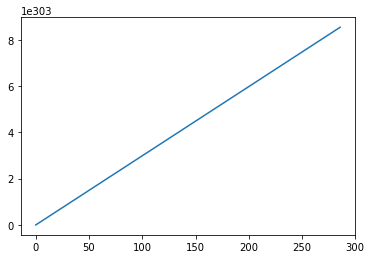

In [43]:
y_rate_of_burg = np.exp(-1.0718 + 2.452*med_inc)
plt.plot(med_inc,y_rate_of_burg);

In [110]:
poisreg_base= (sm.GLM(endog = rate_of_burg['incident_reported'],
                                   exog = sm.add_constant(rate_of_burg[[]]),
                                   family = sm.families.Poisson(),
                                   offset = np.log(rate_of_burg['population']/1000)
                                   )
                             .fit()
                            )

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [111]:
poisreg_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_reported   No. Observations:                  144
Model:                            GLM   Df Residuals:                      143
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -267.34
Date:                Tue, 12 Oct 2021   Deviance:                       129.67
Time:                        12:25:26   Pearson chi2:                     141.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4418      0.049     -8.979      0.000      -0.538      -0.345
==============================================================================
"""

<AxesSubplot:xlabel='median_income', ylabel='rate_of_burg'>

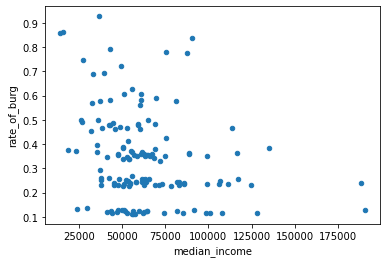

In [55]:

rate_of_burg.plot(kind='scatter', x='median_income', y='rate_of_burg')

In [114]:
median_income_x =np.linspace(14000,200000, 200)

In [115]:
np.exp(poisreg_base.params['const'])

0.6428715969054996

In [116]:
burg_rate_y =np.full_like(median_income_x , np.exp(poisreg_base.params['const']))

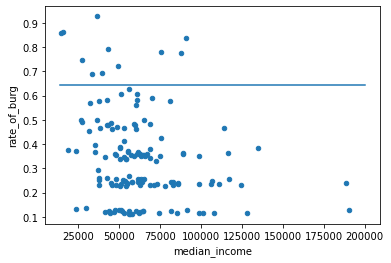

In [117]:
rate_of_burg.plot(kind='scatter', x='median_income', y='rate_of_burg')
plt.plot(median_income_x, burg_rate_y )

In [60]:
from scipy.stats import poisson

In [134]:
poisreg_median_inc= (sm.GLM(endog = rate_of_burg['incident_reported'],
                                   exog = sm.add_constant(rate_of_burg[['median_income']]),
                                   family = sm.families.Poisson(),
                                   offset = np.log(rate_of_burg['population']/1000)
                                   )
                             .fit()
                            )

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [135]:
poisreg_median_inc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_reported   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.55
Date:                Tue, 12 Oct 2021   Deviance:                       112.10
Time:                        12:45:37   Pearson chi2:                     116.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0974      0.138      0.704      0.482      -0.174       0.369
median_income -8.807e-06    2.2e-06     -4.001      0.000   -1.31e-05   -4.49e-06
=================================================================================
"""

In [136]:
poisreg_median_inc.pearson_chi2/poisreg_median_inc.df_resid

0.8158777112321287

In [137]:
np.exp(poisreg_median_inc.params['const'])

1.1023287569419775

In [138]:
median_income_x =np.linspace(14000,200000, 200)

In [139]:
burg_rate_pred =np.full_like(median_income_x , np.exp(poisreg_median_inc.params['const']))

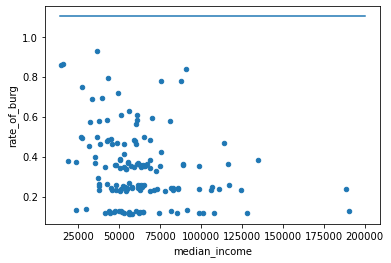

In [140]:
rate_of_burg.plot(kind='scatter', x='median_income', y='rate_of_burg')
plt.plot(median_income_x, burg_rate_pred);

median_income = 25000
mu = np.exp(0.0974-8.807*median_income)
x = np.arange(start=0, stop =25000, step =500)
y= poisson.pmf(x, mu=mu)

plt.bar(x, y, color ='cornflowerblue', edgecolor ='black')
plt.title( "")
plt.ylim(0, 10);

In [70]:
import seaborn as sns

In [141]:
model_NB= (sm.GLM(endog = rate_of_burg['incident_reported'],
                                   exog = sm.add_constant(rate_of_burg[['median_income']]),
                                   family = sm.families.NegativeBinomial(alpha=1),
                                   offset = np.log(rate_of_burg['population']/1000)
                                   )
                             .fit()
                            )

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [127]:
model_NB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_reported   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.48
Date:                Tue, 12 Oct 2021   Deviance:                       30.707
Time:                        12:33:25   Pearson chi2:                     30.2
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0684      0.254      0.269      0.788      -0.430       0.567
median_income   -7.4e-06   3.82e-06     -1.936      0.053   -1.49e-05    9.23e-08
=================================================================================
"""

In [103]:
rate_of_burg.head()

,tract,population,state,county,median_income,incident_reported,rate_of_burg,fit_values
0,010104,2955.0,47,037,64844.0,4,0.500547,1.840158
1,010105,4435.0,47,037,64688.0,3,0.357258,2.765592
2,010106,3397.0,47,037,63864.0,2,0.245983,2.133740
3,010201,4157.0,47,037,62829.0,3,0.360034,2.635025
4,010301,3395.0,47,037,51918.0,1,0.123000,2.369062


<AxesSubplot:xlabel='rate_of_burg', ylabel='median_income'>

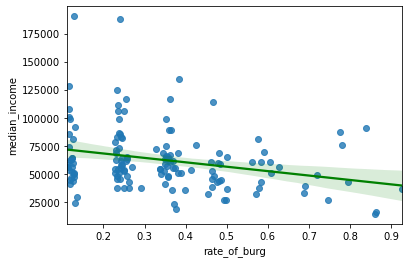

In [143]:
sns.regplot('rate_of_burg','median_income', data=rate_of_burg, fit_reg=True, line_kws={'color':'green','label':'LM fit'})

In [128]:
rate_of_burg['fit_values']=poisreg_median_inc.fittedvalues

C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\U6033919\Anaconda3\envs\geospatial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rate_of_burg', ylabel='median_income'>

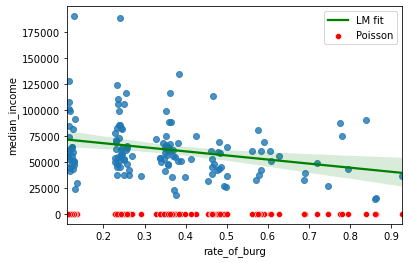

In [145]:
sns.regplot('rate_of_burg','median_income', data=rate_of_burg, fit_reg=True, line_kws={'color':'green','label':'LM fit'})
sns.scatterplot('rate_of_burg','fit_values', data = rate_of_burg,
           color = 'red', label = 'Poisson')